In [1]:
!pip install transformers
!pip install tokenizers
!pip install torchtext
!pip install sentencepiece
!pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Домашнее задание Transformers Training (50 баллов)

В этом домашнем задании требуется обучить несколько Transformer-based моделей в задаче машинного перевода. Для обучения можно воспользоваться текущим проектом, так и реализовать свой пайплайн обучения. Если будете использовать проект, теги **TODO** проекта отмечают, какие компоненты надо реализовать.
В ноутбуке нужно только отобразить результаты обучения и выводы. Архитектура модели(количетсво слоев, размерность и тд) остается на ваш выбор.

Ваш код обучения нужно выложить на ваш github, в строке ниже дать ссылку на него. В первую очередь будут оцениваться результаты в ноутбуке, код нужен для проверки адекватности результатов. 

Обучать модели до конца не нужно, только для демонстрации, что модель обучается и рабочая - снижение val_loss, рост bleu_score.

#### Сcылка на ваш github с проектом(вставить свой) - https://github.com/IgnatPolezhaev/Pipeline-for-T5-translator

Ноутбук с результатами выкладывать на ваш **google диск** курса. 

In [2]:
from huggingface_hub import notebook_login
notebook_login()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/T5/src

/content/drive/MyDrive/T5/src


### Reading data

`
wget https://www.manythings.org/anki/rus-eng.zip && unzip rus-eng.zip
`

Модели нужно обучить на задаче перевода с английского на русский. 

In [ ]:
!wget https://www.manythings.org/anki/rus-eng.zip && unzip rus-eng.zip

--2023-05-19 16:59:53--  https://www.manythings.org/anki/rus-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15460248 (15M) [application/zip]
Saving to: ‘rus-eng.zip.2’

rus-eng.zip.2       100%[===================>]  14.74M  43.0MB/s    in 0.3s    

2023-05-19 16:59:54 (43.0 MB/s) - ‘rus-eng.zip.2’ saved [15460248/15460248]

Archive:  rus-eng.zip
replace rus.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: rus.txt                 
replace _about.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: _about.txt              


### Training Seq2seq Transformer модель(25 баллов)

Реализуйте Seq2seq Transformer. В качестве блока трансформера можно использовать https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html. В качестве токенизатора воспользуйтесь HuggingFace токенизатор для source/target языков - https://huggingface.co/docs/transformers/fast_tokenizers
В качестве максимальной длинны возьмите предложения длинной **до 15 слов**, без каких либо префиксов. 

Не забудьте остальные элементы модели:
* Мы можем использовать 1 трансформер как энкодер - декодером будет выступать линейный слой. 
* Обучите свой BPE токенизатор - https://huggingface.co/docs/transformers/fast_tokenizers
* Матрицу эмбеддингов токенов
* Матрицу позицонных эмбеддингов
* Линейный слой проекции в target словарь
* Функцию маскирования будущих состояний attention, так как модель авто-регрессионна
* Learning rate schedualer


В качестве результатов, приложите слудующие данные:
1) Параметры обучения - learning rate, batch_size, epoch_num, размерность скрытого слоя, количетсво слоев
2) Графики обучения - train loss, val loss, bleu score
3) Примеры переводов вашей модели(10 штук) - source text, true target text, predicted target text

### Fine-tune pretrained T5 (25 баллов)

Реализуйте Seq2seq Pretrained T5. Воспользуйтесь https://huggingface.co/docs/transformers/model_doc/t5 предобученной моделью. В качестве максимальной длинны возьмите предложения длинной **до 15 слов**, без каких либо префиксов. Архитектура модели(количетсво слоев, размерность и тд) остается на ваш выбор.

Не забудьте важные аспекты обучения модели:
* Взять готовый t5 токенизатор
* Resize matrix embedding - скорей всего ваша матрица эмбеддингов не будет включать эмбеддинги из вашего сета. Пример обновления матрицы эмбеддингов тут тут https://github.com/runnerup96/Transformers-Tuning/blob/main/t5_encoder_decoder.py
* Learning rate schedualer/Adafactor with constant learning rate


В качестве результатов, приложите следующие данные:
1) Параметры обучения - learning rate, batch_size, epoch_num, pretrained model name
2) Графики обучения - train loss, val loss, bleu score
3) Примеры переводов вашей модели(10 штук) - source text, true target text, predicted target text

In [4]:
import torch
import yaml
import numpy as np
from models import trainer
from data.datamodule_t5 import DataManager
from txt_logger import TXTLogger
from data.tokenizer_t5 import T5Tokenizer
from models.seq2seq_t5 import Seq2SeqT5

In [5]:
if torch.cuda.is_available():
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'
    
data_config = yaml.load(open("../configs/data_config.yaml", 'r'), Loader=yaml.Loader)
model_config = yaml.load(open("../configs/model_config.yaml", 'r'), Loader=yaml.Loader)
dm = DataManager(data_config, model_config)
train_dataloader, val_dataloader = dm.prepare_data()

Reading from file: 100%|██████████| 467119/467119 [00:07<00:00, 62274.43it/s]


In [6]:
model = Seq2SeqT5(model_config, 
                  device=DEVICE, 
                  tokenizer=dm.tokenizer)

logger = TXTLogger('training_logs')
trainer_cls = trainer.Trainer(model=model, model_config=model_config, logger=logger)

trainer_cls.train(train_dataloader, val_dataloader)

100%|██████████| 500/500 [40:56<00:00,  4.91s/it]

Last 499 epoch train loss:  0.017627154244109988
Last 499 epoch val loss:  2.871693730354309
Last 499 epoch val bleu:  0.25280854860239405


In [9]:
trainer_cls.train(train_dataloader, val_dataloader)

100%|██████████| 500/500 [41:03<00:00,  4.93s/it]

Last 499 epoch train loss:  1.4516656696796417
Last 499 epoch val loss:  1.6366457343101501
Last 499 epoch val bleu:  0.04786694559580815


In [9]:
import yaml

with open('../configs/model_config.yaml', 'r') as model_config:
    try:
        print(yaml.safe_load(model_config))
    except yaml.YAMLError as exc:
        print(exc)

{'model': 't5-small', 'token': 't5-small', 'embedding_size': 512, 'hidden_size': 512, 'learning_rate': 5e-05, 'epoch_num': 500}


In [10]:
import yaml

with open('../configs/data_config.yaml', 'r') as data_config:
    try:
        print(yaml.safe_load(data_config))
    except yaml.YAMLError as exc:
        print(exc)

{'prefix_filter': ['he is', 'he s ', 'she is', 'she s '], 'max_length': 15, 'filename': 'rus.txt', 'train_size': 0.8, 'batch_size': 128}


In [7]:
model.predict(['Hi, my name is Ignat', 
               'How are you?', 
               'He is artist', 
               'She likes tea', 
               'I love mother', 
               'Cat and dog', 
               'Moscow is a capital of Russia', 
               'The weather is good', 
               'What are you doing?', 
               'She is doing her homework'])

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['он изз тот из',
 'он тебя ас',
 'он уж итель',
 'онап ох актуаль',
 'она люб ит матьч',
 'и лучш ает и ск',
 'он мужя ой нуж',
 'онх орош ий в оч',
 'теб ез делает',
 'она делает свою дома']

In [11]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [11]:
import random

source_text = []
true_target_text = []
predicted_target_text = []

with open('./rus.txt') as file:
    lines = [line.rstrip() for line in file]

n = 10
for i in range(n):
    seq = random.choice(lines)
    seq = seq.split('\t')
    source_text.append(seq[0])
    true_target_text.append(seq[1])

predicted_target_text = model.predict(source_text)

for i in range(n):
    print('source text: ', source_text[i])
    print('true target text: ', true_target_text[i])
    print('predicted target text: ', predicted_target_text[i])
    print('_________________________________________________')

source text:  I took it for granted that you were on our side.
true target text:  Я считал само собой разумеющимся, что вы на нашей стороне.
predicted target text:  он доч е нет до
_________________________________________________
source text:  Wait. I can't walk that fast.
true target text:  Подожди. Я не могу идти так быстро.
predicted target text:  он не такой оч ий
_________________________________________________
source text:  I hope you'll be happy forever.
true target text:  Надеюсь, ты будешь счастлив всегда.
predicted target text:  она для номной о
_________________________________________________
source text:  I don't think that Tom knows that I'm Canadian.
true target text:  Не думаю, что Том знает, что я канадец.
predicted target text:  у нег о тног о 
_________________________________________________
source text:  I have bad news.
true target text:  У меня плохие вести.
predicted target text:  у нег о мнег ом
_________________________________________________
source text:  

In [13]:
import ast

path_to_logs = './training_logs/progress_log.txt'
train_loss = []
val_loss = []
bleu_score = []

with open(path_to_logs) as file:
    lines = [line.rstrip() for line in file]

for i in range(1,len(lines)):
    line_dict = ast.literal_eval(lines[i])
    train_loss.append(line_dict['train_loss'])
    val_loss.append(line_dict['val_loss'])
    bleu_score.append(line_dict['bleu_score'])

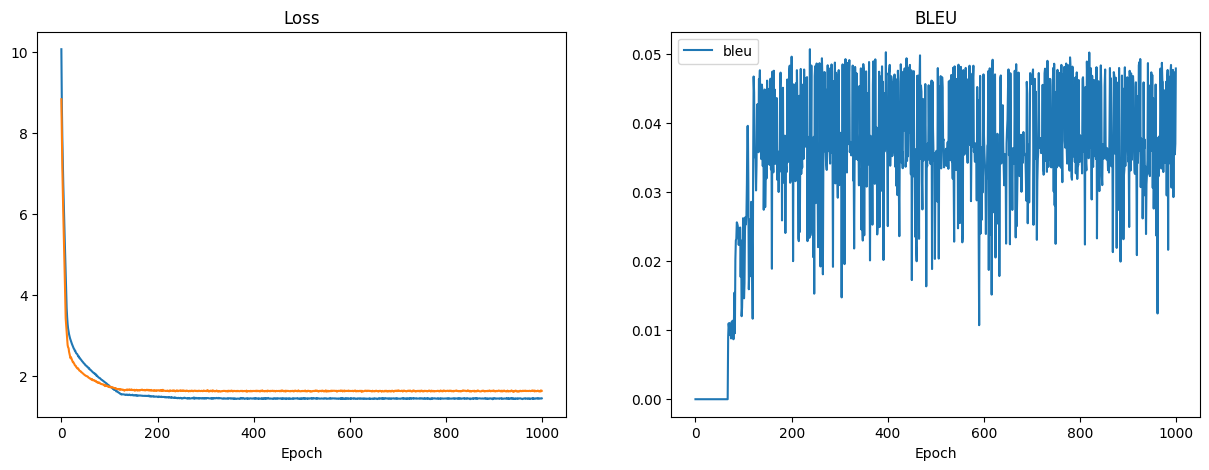

In [14]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

ax[0].plot(train_loss, label='train loss')
ax[0].plot(val_loss, label='val loss')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Loss')

ax[1].plot(bleu_score, label='bleu')
ax[1].set_xlabel('Epoch')
ax[1].set_title('BLEU')

plt.legend()
plt.show()